In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,5.612824,level_62,level_265,level_48,level_252,level_210,level_248,level_198,level_425,level_193,...,level_281,level_102,level_98,level_66,level_254,level_116,level_490,level_17,level_153,level_274
1,9.781479,level_157,level_96,level_158,level_7,level_131,level_236,level_74,level_337,level_398,...,level_307,level_183,level_270,level_483,level_375,level_375,level_150,level_398,level_123,level_385
2,24.762201,level_340,level_116,level_15,level_424,level_441,level_169,level_168,level_359,level_499,...,level_235,level_442,level_365,level_492,level_129,level_276,level_380,level_122,level_255,level_424
3,-8.259976,level_159,level_381,level_434,level_37,level_0,level_405,level_101,level_415,level_439,...,level_197,level_281,level_272,level_434,level_416,level_248,level_157,level_94,level_102,level_75
4,22.383576,level_112,level_476,level_95,level_350,level_123,level_3,level_311,level_250,level_129,...,level_194,level_252,level_53,level_460,level_184,level_420,level_270,level_16,level_189,level_80


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,9.069368,5.124469,2.251496,-1.881817,12.814613,-3.988360,2.876202,3.313952,-0.181075,8.843699,...,19.350987,0.086498,14.418191,-3.918675,5.293878,0.205885,-17.213981,7.306974,0.688925,3.248453
1,5.986828,6.956404,4.987682,4.532850,14.930656,15.665662,10.156309,-3.002525,11.808948,8.231309,...,4.287970,1.076953,2.332530,5.979720,11.845690,7.400692,-1.213115,0.948348,0.159394,10.221700
2,-1.596937,-3.895211,-6.692355,13.225546,-11.848439,1.034685,0.579889,8.163166,-7.201374,-5.197754,...,-5.325057,-11.495224,16.132943,-4.910160,-9.542066,8.849187,-1.652261,0.596152,13.927243,-11.828104
3,-7.490469,-5.606980,-8.702736,0.124469,-29.164881,-3.072719,-9.841656,-16.243784,-4.409513,-16.727386,...,-6.565692,-19.118281,7.847837,-1.122846,-8.542370,-3.404940,-7.326184,-12.024362,1.366518,-7.819269
4,10.511496,-9.459946,-31.894900,5.389742,-12.287653,-19.538169,-6.463204,-17.321549,-5.369099,-10.304701,...,-17.396499,-9.904341,0.756485,-26.353427,-7.946874,-1.581962,-11.084352,-23.226834,0.302160,-8.915344


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,5.412212,4.566155,1.524570,-1.315265,7.243818,-2.269970,1.194214,2.562187,-0.102338,7.750176,...,14.169087,0.069676,6.830519,-1.733507,4.039002,0.127725,-7.467623,4.945990,0.506520,2.583258
1,2.680551,3.916467,1.870928,1.472189,9.527213,11.186039,4.477796,-0.540958,8.106802,4.315440,...,2.540150,0.700212,1.329744,2.244387,8.577374,2.529724,-0.741137,0.542164,0.117107,6.806742
2,-1.307509,-3.005390,-4.031078,9.650270,-7.977851,0.749472,0.308186,6.146499,-4.047018,-4.239865,...,-2.874641,-4.542496,8.689693,-3.399408,-4.131917,5.035061,-1.214960,0.414838,5.004716,-6.539290
3,-5.500988,-2.732052,-6.540160,0.094118,-26.771271,-1.903411,-7.187739,-7.870491,-2.694786,-4.748130,...,-3.959674,-8.743964,3.491273,-0.758338,-5.437359,-2.499249,-5.538443,-4.881262,0.864844,-6.339950
4,7.567762,-3.591179,-27.557458,2.140106,-8.093568,-1.254053,-3.483666,-3.250374,-2.553713,-3.907722,...,-6.025974,-0.300505,0.363453,-2.178603,-2.934826,-1.083299,-6.894208,-10.461132,0.094647,-3.489601


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,4.205235,3.038303,-0.039063,-2.682131e+00,8.374686,-4.677523e+00,0.381481,1.197500,-1.142435,9.077023,...,8.121174,-1.816356e+00,6.991740,-5.540698,1.393561,-3.541454e+00,-26.012120,3.957188,-2.244082,-0.506676
1,-3.789932,2.197010,-2.724643,2.775558e-17,8.259572,9.050335e+00,2.235645,-1.743224,2.588381,1.276264,...,-3.462725,1.999934e+00,0.259863,-3.225219,6.647519,-2.775558e-17,-2.144928,-2.441552,0.270249,1.069413
2,-0.281433,-3.205772,-2.668123,1.341867e+01,-7.383492,2.188681e+00,1.242210,6.936452,4.453817,-3.637945,...,3.543008,-2.775558e-17,9.602165,-3.466986,0.000000,9.689806e+00,1.648215,1.629159,6.164720,-5.661896
3,-4.719922,-0.476530,-4.146285,4.429646e+00,-30.299736,1.188587e+01,-5.748817,-5.931178,2.515903,-1.355936,...,-1.557524,-7.117576e+00,9.124245,1.274188,-3.097083,-8.840158e-01,-3.149538,-0.921858,4.185013,-4.034031
4,14.469672,-2.311498,-27.145556,9.266150e+00,-8.928447,-2.775558e-17,-0.511791,-1.111897,3.749354,-1.340609,...,-4.163361,2.775558e-17,8.641870,0.000000,-1.356042,1.502883e+00,1.070981,-9.012713,2.717972,2.230429


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.528832,0.501441,0.160898,0.196836,False
1,var_1_impact_code,0.534272,0.514283,0.194492,0.180484,False
2,var_2_impact_code,0.518892,0.486258,0.146825,0.202501,False
3,var_3_impact_code,0.525013,0.501445,0.152538,0.177370,False
4,var_4_impact_code,0.536584,0.514352,0.184291,0.119218,False
5,var_5_impact_code,0.527631,0.505593,0.166435,0.165996,False
6,var_6_impact_code,0.531185,0.505659,0.165415,0.167598,False
7,var_7_impact_code,0.521722,0.496200,0.151284,0.210813,False
8,var_8_impact_code,0.523210,0.493476,0.140208,0.206677,False
9,var_9_impact_code,0.510064,0.484467,0.143189,0.141181,False


(0.8429406570760497, 7.618838368688349e-31)


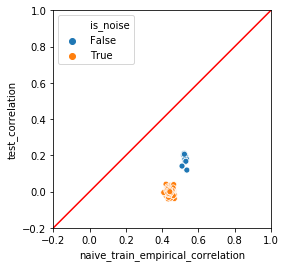

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.832014331851452, 2.114526726806534e-29)


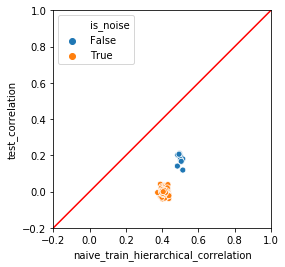

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.7784528807961337, 1.4057789211437034e-23)


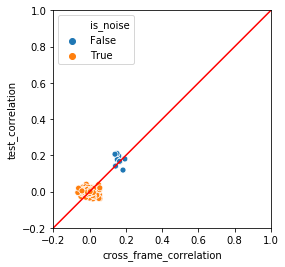

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,orig_variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,noise_95,impact_code,True,True,0.006774,0.731969,110.0,False
106,noise_96_impact_code,noise_96,impact_code,True,True,0.020607,0.297398,110.0,False
107,noise_97_impact_code,noise_97,impact_code,True,True,-0.042066,0.033346,110.0,False
108,noise_98_impact_code,noise_98,impact_code,True,True,0.003390,0.863888,110.0,False
109,noise_99_impact_code,noise_99,impact_code,True,True,0.002996,0.879614,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_22_impact_code',
 'noise_26_impact_code',
 'noise_57_impact_code',
 'noise_79_impact_code',
 'noise_87_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,5.612824,2.395541,1.583380,-2.426783,-3.766126
1,22.383576,-2.992619,-3.397405,-3.041433,-4.816080
2,-4.092852,2.347191,1.550881,-0.843212,-1.308225
3,21.297294,6.413551,12.374617,4.566090,8.331720
4,-26.509427,-1.519864,-2.848869,-2.301531,-3.219411


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.2659177687781873


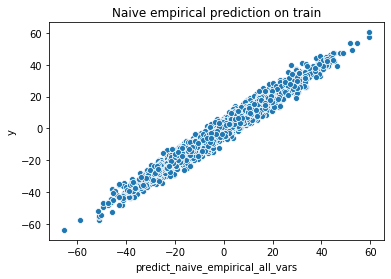

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.828304945536409


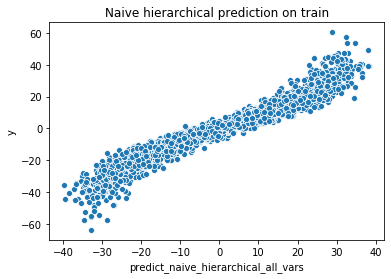

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.406989033805184


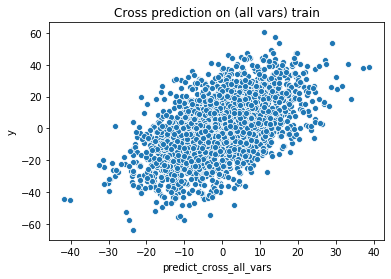

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.816664744149948


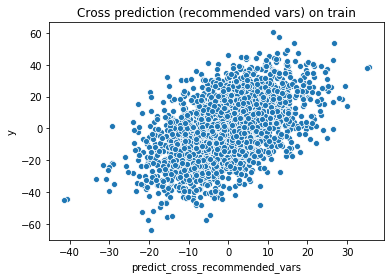

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.549312129750515


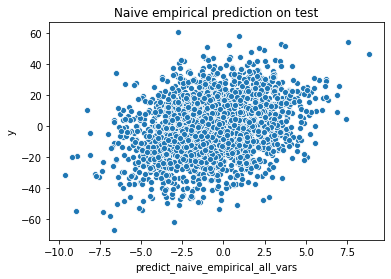

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.230183601537835


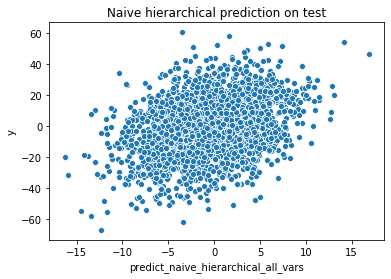

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.626963577983883


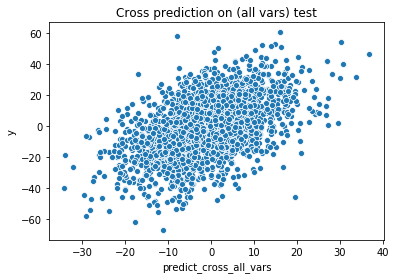

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.241950440045379


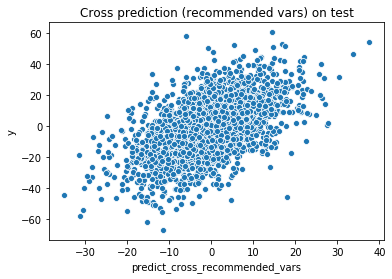

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                     690.0
Date:                Tue, 30 Jul 2019   Prob (F-statistic):               0.00
Time:                        21:22:50   Log-Likelihood:                -6659.7
No. Observations:                2559   AIC:                         1.354e+04
Df Residuals:                    2448   BIC:                         1.419e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.5123      0.066     -7.761      0.000      -0.642      -0.383
var_0_impact_code        0.0751      0.008      9.365      0.000       0.059       0.091
var_1_impact_code        0.0669      0.008      8.366      0.000       0.051       0.083
var_2_impact_code        0.0830      0.008     10.153      0.000       0.067       0.099
var_3_impact_code        0.0617      0.008      7.607      0.000       0.046       0.078
var_4_impact_code        0.0578      0.008      7.260      0.000       0.042       0.073
var_5_impact_code        0.0574      0.008      7.130      0.000       0.042       0.073
var_6_impact_code        0.0642      0.008      7.999      0.000       0.048       0.080
var_7_impact_code        0.0589      0.008      7.265      0.000       0.043       0.075
var_8_impact_code        0.0717      0.008      8.791      0.000       0.056       0.088
var_9_impact_code        0.0671      0.008      8.173      0.000       0.051       0.083
noise_0_impact_code      0.0378      0.009      4.197      0.000       0.020       0.056
noise_1_impact_code      0.0448      0.009      4.881      0.000       0.027       0.063
noise_2_impact_code      0.0328      0.009      3.603      0.000       0.015       0.051
noise_3_impact_code      0.0335      0.009      3.541      0.000       0.015       0.052
noise_4_impact_code      0.0345      0.009      3.761      0.000       0.017       0.052
noise_5_impact_code      0.0324      0.009      3.459      0.001       0.014       0.051
noise_6_impact_code      0.0488      0.009      5.295      0.000       0.031       0.067
noise_7_impact_code      0.0683      0.009      7.551      0.000       0.051       0.086
noise_8_impact_code      0.0409      0.009      4.498      0.000       0.023       0.059
noise_9_impact_code      0.0570      0.009      6.078      0.000       0.039       0.075
noise_10_impact_code     0.0398      0.009      4.455      0.000       0.022       0.057
noise_11_impact_code     0.0365      0.009      4.004      0.000       0.019       0.054
noise_12_impact_code     0.0385      0.009      4.176      0.000       0.020       0.057
noise_13_impact_code     0.0413      0.009      4.613      0.000       0.024       0.059
noise_14_impact_code     0.0362      0.009      3.830      0.000       0.018       0.055
noise_15_impact_code     0.0332      0.009      3.624      0.000       0.015       0.051
noise_16_impact_code     0.0523      0.009      5.717      0.000       0.034       0.070
noise_17_impact_code     0.0339      0.009      3.709      0.000       0.016       0.052
noise_18_impact_code     0.0357      0.009      4.003      0.000       0.018       0.053
noise_19_impact_code     0.0514      0.009      5.664      0.000       0.034       0.069
noise_20_impact_code     0.0550      0.009      5.927    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9687542649079539

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.0668452436469934

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     9.749
Date:                Tue, 30 Jul 2019   Prob (F-statistic):          8.67e-126
Time:                        21:22:50   Log-Likelihood:                -10629.
No. Observations:                2559   AIC:                         2.148e+04
Df Residuals:                    2448   BIC:                         2.213e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4549      0.316     -1.439      0.150      -1.075       0.165
var_0_impact_code        0.4239      0.047      8.985      0.000       0.331       0.516
var_1_impact_code        0.4665      0.046     10.233      0.000       0.377       0.556
var_2_impact_code        0.4261      0.047      9.078      0.000       0.334       0.518
var_3_impact_code        0.4043      0.045      8.888      0.000       0.315       0.494
var_4_impact_code        0.4322      0.044      9.776      0.000       0.346       0.519
var_5_impact_code        0.4188      0.046      9.114      0.000       0.329       0.509
var_6_impact_code        0.4244      0.045      9.433      0.000       0.336       0.513
var_7_impact_code        0.4101      0.048      8.504      0.000       0.316       0.505
var_8_impact_code        0.3705      0.046      8.102      0.000       0.281       0.460
var_9_impact_code        0.4071      0.050      8.224      0.000       0.310       0.504
noise_0_impact_code      0.0455      0.057      0.800      0.424      -0.066       0.157
noise_1_impact_code     -0.0234      0.060     -0.389      0.697      -0.141       0.094
noise_2_impact_code      0.0501      0.058      0.859      0.390      -0.064       0.165
noise_3_impact_code     -0.1559      0.061     -2.536      0.011      -0.276      -0.035
noise_4_impact_code     -0.0862      0.059     -1.468      0.142      -0.201       0.029
noise_5_impact_code      0.0638      0.060      1.058      0.290      -0.054       0.182
noise_6_impact_code      0.0090      0.057      0.157      0.875      -0.103       0.121
noise_7_impact_code      0.0478      0.061      0.779      0.436      -0.073       0.168
noise_8_impact_code      0.0463      0.056      0.823      0.410      -0.064       0.156
noise_9_impact_code     -0.1377      0.061     -2.275      0.023      -0.257      -0.019
noise_10_impact_code    -0.0312      0.055     -0.563      0.574      -0.140       0.077
noise_11_impact_code     0.0143      0.057      0.251      0.802      -0.097       0.126
noise_12_impact_code     0.0495      0.056      0.892      0.373      -0.059       0.158
noise_13_impact_code    -0.0323      0.056     -0.578      0.563      -0.142       0.077
noise_14_impact_code    -0.0129      0.058     -0.222      0.825      -0.127       0.101
noise_15_impact_code     0.0312      0.057      0.548      0.584      -0.080       0.143
noise_16_impact_code     0.0639      0.058      1.094      0.274      -0.051       0.178
noise_17_impact_code     0.0333      0.059      0.567      0.571      -0.082       0.149
noise_18_impact_code     0.0768      0.055      1.403      0.161      -0.031       0.184
noise_19_impact_code    -0.0359      0.057     -0.634      0.526      -0.147       0.075
noise_20_impact_code    -0.0813      0.060     -1.361    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.3046302371669174

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.26008355946249495

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     61.80
Date:                Tue, 30 Jul 2019   Prob (F-statistic):          3.59e-159
Time:                        21:22:50   Log-Likelihood:                -10697.
No. Observations:                2559   AIC:                         2.143e+04
Df Residuals:                    2543   BIC:                         2.152e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.4725      0.315     -1.502      0.133      -1.089       0.144
var_0_impact_code        0.4372      0.047      9.376      0.000       0.346       0.529
var_1_impact_code        0.4861      0.045     10.810      0.000       0.398       0.574
var_2_impact_code        0.4286      0.046      9.271      0.000       0.338       0.519
var_3_impact_code        0.4017      0.045      8.889      0.000       0.313       0.490
var_4_impact_code        0.4408      0.044     10.039      0.000       0.355       0.527
var_5_impact_code        0.4324      0.046      9.475      0.000       0.343       0.522
var_6_impact_code        0.4195      0.045      9.405      0.000       0.332       0.507
var_7_impact_code        0.4269      0.048      8.959      0.000       0.333       0.520
var_8_impact_code        0.3891      0.045      8.626      0.000       0.301       0.478
var_9_impact_code        0.4234      0.049      8.642      0.000       0.327       0.519
noise_22_impact_code     0.1160      0.056      2.079      0.038       0.007       0.225
noise_26_impact_code     0.1231      0.054      2.299      0.022       0.018       0.228
noise_57_impact_code     0.0931      0.057      1.646      0.100      -0.018       0.204
noise_79_impact_code     0.1601      0.055      2.917      0.004       0.052       0.268
noise_87_impact_code     0.0960      0.055      1.735      0.083      -0.012       0.204
==============================================================================
Omnibus:                        0.867   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.648   Jarque-Bera (JB):                0.913
Skew:                           0.041   Prob(JB):                        0.633
Kurtosis:                       2.958   Cond. No.                         7.32
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.26715846841655533

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.29609416113937315